### 正規化をしてテキストファイルに起こすノートブックです

In [80]:
import glob
import math

def split_list(l,n):
    for idx in range(0,len(l)-1,n):
        yield l[idx:idx + n]

def normalize_points(path,xmin,xmax,ymin,ymax,normalize):
    #LiDARからの生のデータを入力してね
    files = glob.glob(path)
    if len(files) == 0:
        print('No data available')
        return 
    with open(files[0],'r') as f:
        data = f.read().split('\n')
    normalize_x = []
    normalize_y = []
    for idx in range(1,len(data)-1):
        d_k = data[idx].replace('(','').replace(')',',').replace('[','').replace(']','')
        sp_ka = d_k.split(',')
        angl = [] #角度
        dist = [] #距離
        result = list(split_list(sp_ka,3))
        for idx in range(len(result)):
            angl.append(float(result[idx][1]))
            dist.append(float(result[idx][2]))

        points_x = []
        points_y = []
        for i in range(len(angl)):
            x = dist[i] * math.cos(math.radians(angl[i])) 
            y = math.sqrt(dist[i] ** 2 - x ** 2) 
            x = x / 10
            y = y / 10
            if(0 <= float(angl[i]) and float(angl[i]) <= 90):
                points_x.append(x)
                points_y.append(-y)
            elif(90 < float(angl[i]) and float(angl[i]) <= 180):
                points_x.append(x)
                points_y.append(-y)
            elif(180 < float(angl[i]) and float(angl[i]) <= 270):
                points_x.append(x)
                points_y.append(y)
            else:
                points_x.append(x)
                points_y.append(y)
        #ここで座標指定をしてしまうのがベスト？

        if normalize == 1:
            if xmin == -1 and xmax == -1:
                xmin = min(points_x)
                xmax = max(points_x)
                ymin = min(points_y)
                ymax = max(points_y)
            human_x = []
            human_y = [] 
            for point_x,point_y in zip(points_x,points_y):
                if xmin <= point_x and point_x <= xmax and ymin <= point_y and point_y <= ymax:
                    human_x.append(point_x)
                    human_y.append(point_y)
            max_points_x = max(human_x)
            min_points_x = min(human_x)
            max_points_y = max(human_y)
            min_points_y = min(human_y)
            bo_x = max_points_x - min_points_x
            bo_y = max_points_y - min_points_y
            n_x = []
            n_y = []
            for h_x in human_x:
                n_x.append((h_x - min_points_x) / bo_x)
            for h_y in human_y:
                n_y.append((h_y - min_points_y) / bo_y)
            normalize_x.append(n_x)
            normalize_y.append(n_y)
        else:
            human_x = []
            human_y = []
            if xmin == -1 and xmax == -1:
                xmin = min(points_x)
                xmax = max(points_x)
                ymin = min(points_y)
                ymax = max(points_y)
            for point_x,point_y in zip(points_x,points_y):
                if xmin <= point_x and point_x <= xmax and ymin <= point_y and point_y <= ymax:
                    human_x.append(point_x)
                    human_y.append(point_y)
            n_x = []
            n_y = []
            for h_x,h_y in zip(human_x,human_y):
                n_x.append(h_x)
                n_y.append(h_y)
            normalize_x.append(n_x)
            normalize_y.append(n_y)
    return normalize_x,normalize_y,normalize

In [113]:
path = r'C:\Users\wtana\Desktop\LiDAR_cm\lidar_txt_files\wall_3.txt'
#plotの範囲を全部にするならxmin and xmax に-1
#normalizeするなら1
#しないなら0
x,y,no = normalize_points(path,xmin=-400,xmax=-225,ymin=-500,ymax=0,normalize=1)
#x,y,no = normalize_points(path,xmin=-1,xmax=-1,ymin=0,ymax=500,normalize=0)

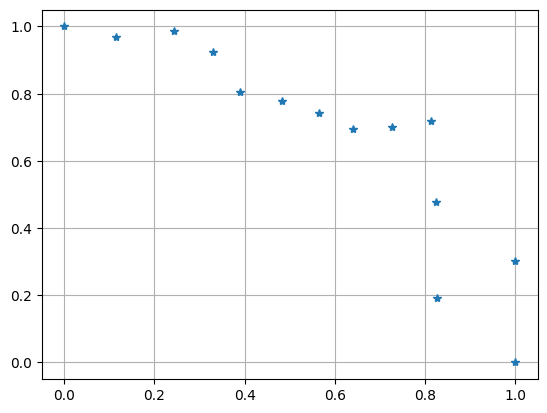

In [114]:
import matplotlib.pyplot as plt
plt.plot(x[5],y[5],linestyle='',marker='*')
plt.grid('TRUE')
#plt.savefig('../md_matome/images/tree_right_normalize.png')

In [96]:
s = ''
for i in range(len(x)):
    s = ''
    with open('./normalize_txt/wall/'+str(i)+'.txt','a') as f:
        for x_,y_ in zip(x[i],y[i]):
            s = s + str(x_) + ' ' + str(y_) + ' 40\n'
        f.write(s)



In [9]:
s

'0.9120298838130259 1.0 95\n0.9000239267754437 0.9236224442617277 95\n0.8530375483182776 0.8432134516178998 95\n0.5897246564520376 0.7588806795274123 95\n0.39525592077157196 0.6827593365456596 95\n0.2545384555567279 0.6055014876481026 95\n0.03672297974033477 0.5315118036697246 95\n0.0 0.45826613209347034 95\n0.17286538039110108 0.3896190221509823 95\n0.41320668414052647 0.31622685727541205 95\n0.584577070657579 0.2394034603455049 95\n0.8497559604920741 0.1568736723968907 95\n0.8737120471348135 0.08029839250171875 95\n1.0 0.0 95\n'

In [97]:
from model import *
#from sampler import *
from self_made import *

loss = []
Accu = []

batch_size = 64
num_points = 64
num_labels = 1
def main_():
    pointnet = PointNet(num_points, num_labels)

    new_param = pointnet.state_dict()
    new_param['main.0.main.6.bias'] = torch.eye(3, 3).view(-1)
    new_param['main.3.main.6.bias'] = torch.eye(64, 64).view(-1)
    pointnet.load_state_dict(new_param)

    criterion = nn.BCELoss()
    optimizer = optim.Adam(pointnet.parameters(), lr=0.001)

    loss_list = []
    accuracy_list = []

    for iteration in range(200):

        pointnet.zero_grad()
        input_data, labels = data_sampler(path_1='./normalize_txt/takuya/150cm/*',path_2='./normalize_txt/wall/*')
        #input_data, labels = data_sampler(batch_size, num_points)

        output = pointnet(input_data)
        output = nn.Sigmoid()(output)

        error = criterion(output, labels)
        error.backward()

        optimizer.step()

        with torch.no_grad():
            output[output > 0.5] = 1
            output[output < 0.5] = 0
            accuracy = (output==labels).sum().item()/batch_size

        loss_list.append(error.item())
        accuracy_list.append(accuracy)
        loss.append(float(error.item()))
        Accu.append(float(accuracy))
        if iteration % 10 == 0:

            print('Iteration : {}   Loss : {}'.format(iteration, error.item()))
            print('Iteration : {}   Accuracy : {}'.format(iteration, accuracy))
            

In [98]:
main_()

RuntimeError: Sizes of tensors must match except in dimension 0. Expected size 32 but got size 80 for tensor number 1 in the list.

In [1]:
import matplotlib.pyplot as plt
a_len = len(Accu)
x_ = list(range(len(Accu)))
plt.title('pointnet_result')
plt.plot(x_,Accu,marker='.',label='Accuracy')
plt.plot(x_,loss,marker='.',label='loss')
plt.legend()
plt.savefig('./pointnet_tree_human.png')

NameError: name 'Accu' is not defined